## Objective
In this exercise, your goal is to correctly identify digits from a dataset of handwritten images.

The dataset contains gray-scale images of hand-drawn digits, from zero through nine. It contains 42,000 images.
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
The data set, has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

You are expected to:
- Experiment with different models and settings and decide on the best model for this dataset
- Write a brief report (2-4 pages maximum) describing the choices you made and the evaluation you performed

### Import Libraries


In [89]:
# Basic packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

# Utilities
import os 
import gc

### Load the Dataset

In [16]:
all_digits     = pd.read_csv('digit_recognizer_dataset.csv')

### Data Overview

In [18]:
all_digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


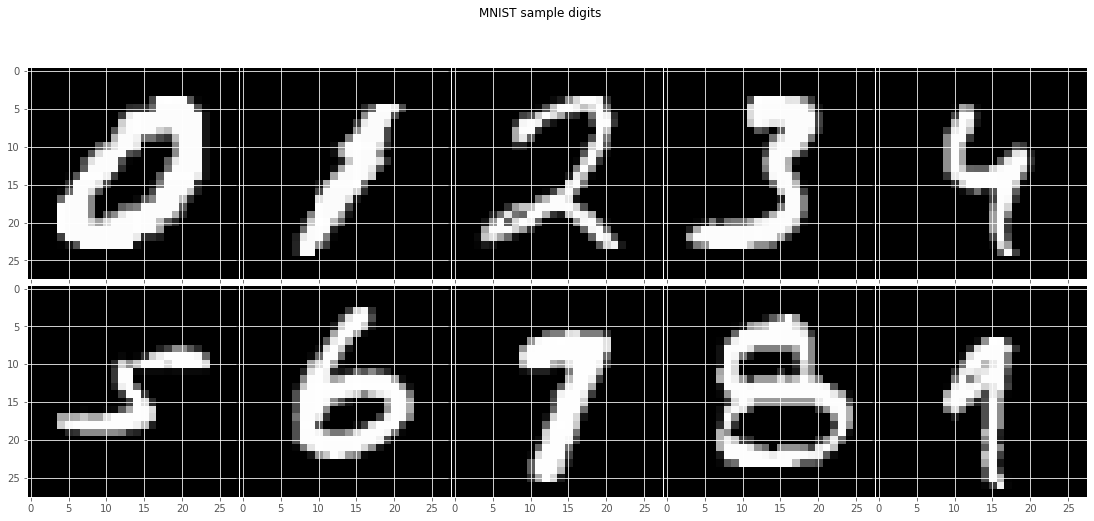

In [121]:
def print_digit():
    fig, axs = plt.subplots(2,5,sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(19,8))
    fig.suptitle('MNIST sample digits')
    for i in range(0,10):
        digit = all_digits.loc[all_digits['label'] == i]
        digit = digit.iloc[random.randint(0, len(digit.index))][1:]
        digit = np.array(digit, dtype='float')
        pixels = digit.reshape((28, 28))
        axs[int(i/5), i % 5].imshow(pixels, cmap='gray')


print_digit()

### Train / Test Split

In [43]:
features = all_digits.columns[1:]
X = all_digits[features]
y = all_digits['label']
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.1,random_state=0)

### Models Declaration


In [54]:

# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('kNN', KNeighborsClassifier()))
models.append(('DT',  DecisionTreeClassifier()))
models.append(('XGB',  XGBClassifier()))
models.append(('MLP',  MLPClassifier()))
models.append(('RF',  RandomForestClassifier()))
models.append(('SVM', SVC()))

In [55]:
results = []
names   = []
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, scoring='accuracy', n_jobs= -1, verbose=2)
  results.append(cv_results)
  names.append(name)
  print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 LR: 0.917487 (+/- 0.002200)
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
LDA: 0.863915 (+/- 0.005749)
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.2min remaining: 12.2min
kNN: 0.964947 (+/- 0.002793)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.

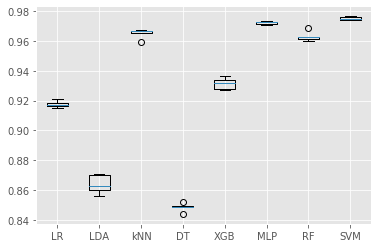

In [61]:
plt.boxplot(results)
plt.xticks(list(range(1,len(names)+1)), names)
plt.show()

### Model Train

[0]	validation_0-merror:0.103598	validation_1-merror:0.135952
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.077937	validation_1-merror:0.102381
[2]	validation_0-merror:0.065132	validation_1-merror:0.093571
[3]	validation_0-merror:0.059153	validation_1-merror:0.087143
[4]	validation_0-merror:0.055265	validation_1-merror:0.084286
[5]	validation_0-merror:0.052619	validation_1-merror:0.082857
[6]	validation_0-merror:0.049524	validation_1-merror:0.08119
[7]	validation_0-merror:0.046984	validation_1-merror:0.078571
[8]	validation_0-merror:0.043942	validation_1-merror:0.076905
[9]	validation_0-merror:0.042434	validation_1-merror:0.075476
[10]	validation_0-merror:0.040238	validation_1-merror:0.072857
[11]	validation_0-merror:0.038439	validation_1-merror:0.070952
[12]	validation_0-merror:0.03672	validation_1-merror:0.068571
[13]	validation_0-merror:0.035

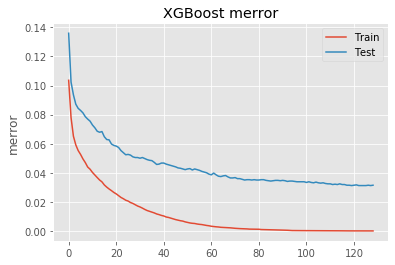

In [117]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

# fit model no training data
model = xgb.XGBClassifier(n_estimators=500,n_jobs=-1,max_depth=7,subsample=0.9)
eval_set = [(X_train,y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["merror"], eval_set=eval_set, verbose=True)
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot Accuracy
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('merror')
pyplot.title('XGBoost merror')
pyplot.show()

